In [1]:
import cv2
import base64
import numpy as np
import matplotlib.pyplot as plt

## 1. Image Preprocessing
---

In [2]:
# Image Preprocessing Params
blurr_kernel_size = 5
risize_factor = 2

# Line Approximation Params
fixed_epsilon = 1.0

use_dynamic_epsilon = False
epsilon_factor = 0.02
max_epsilon = 2.5
min_epsilon = 1.5

# Shortest Path
start_point = np.array([0, 0])

# GCODE Params
z_safe_hight = 10.0
z_working_hight = 0.5
z_zero_height = 0
z_feed_height = -3
z_feed = 500
xy_feed = 1000
spindle_speed = 24000

# Maximaler Vorschub ist ca. 3000 (immer bei G0) (3000mm pro Minute)
g0_feed = 3000

In [3]:
# Custom Image
edge_image_custom = np.array([
       [  0,   0,   0,   0,   0,   0,   0, 255,   0,   0],
       [  0,   0,   0,   0,   0,   0, 255,   0,   0,   0],
       [  0,   0,   0, 255,   0, 255,   0,   0,   0,   0],
       [  0,   0,   0, 255,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 255,   0,   0,   0,   0,   0, 255],
       [  0,   0,   0, 255,   0,   0,   0,   0, 255,   0],
       [  0,   0,   0,   0,   0,   0,   0, 255,   0,   0],
       [  0,   0,   0,   0,   0,   0, 255, 255, 255,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 255]]).astype(np.uint8)

# Preloaded Image
preloaded_images = None
with open("../preloaded_images.txt", "r") as file:
    preloaded_images = eval(file.read())
selected_diff_image = preloaded_images[2]

# Convert image
decoded_image = base64.b64decode(selected_diff_image.split(',')[1])
image_array = np.frombuffer(decoded_image, dtype=np.uint8)
origial = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
gray = cv2.cvtColor(origial, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (blurr_kernel_size, blurr_kernel_size), 0)
edges = cv2.Canny(blurred, 100, 200)
edge_image_preloaded = cv2.resize(edges, (edges.shape[1] // risize_factor, edges.shape[0] // risize_factor))

## 1. Edge Approximation
---

In [4]:
def getEdgeApprox(edge_image):
       contours, _ = cv2.findContours(edge_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
       edge_approximations = []

       for i in range(len(contours)):
              edge_approx = cv2.approxPolyDP(contours[i], fixed_epsilon, True)
              
              # remove last element if it is already in contour
              if edge_approx[-1] in edge_approx[:len(edge_approx)-2]:
                     edge_approx = edge_approx[:-1]
              
              edge_approximations.append(edge_approx)
       
       return edge_approximations


def plotEdgeApprox(edge_image, edge_approximations, markersize):
       # Plot des Edge-Bildes
       plt.imshow(edge_image, cmap='gray')
       for edge_approx in edge_approximations:
              x_approx = edge_approx[:, :, 0].flatten()
              y_approx = edge_approx[:, :, 1].flatten()
              plt.plot(x_approx, y_approx, color='blue')
              plt.plot(x_approx, y_approx, 'ro', markersize=markersize)

       plt.title('Edge Approximation')
       plt.axis('scaled')
       plt.show()

In [5]:
# custom edges
edge_approximations_custom = getEdgeApprox(edge_image_custom)
# plotEdgeApprox(edge_image_custom, edge_approximations_custom, 5)

edge_approximations_preloaded = getEdgeApprox(edge_image_preloaded)
# plotEdgeApprox(edge_image_preloaded, edge_approximations_preloaded, 1.5)

## 2. Shortest Path
---

In [6]:
# Calculate the Distance between contours (to be minimized)
def calculate_g0_distance(contours):
    total_distance = 0
    start_end_point = np.array([0, 0])
    recent_contour_end = start_end_point

    for contour in contours:
        contour_points = contour.squeeze()
        start = contour_points[0] # set startPoint of Contour
        total_distance += np.linalg.norm(start - recent_contour_end)  # Calc euklidian dinstance
        recent_contour_end = contour_points[-1] # set endPoint of Contour

    total_distance += np.linalg.norm(np.array([0, 0]) - recent_contour_end)

    return total_distance

### 2.1 Heuristic Algorithm (Nearest Neighbor)
---
- Pros: You get relatively fast a good result
- Cons: You will not find very good paths, because the algorithm uses only the current and the last contour

In [7]:
from scipy.spatial.distance import cdist

def getContourStartPoint(contours):
    contour_start_points = []
    contour_mapping = []
    for i, contour in enumerate(contours):
        contour_start_points.append(np.array(contour[0][0])) # start_point
        contour_start_points.append(np.array(contour[-1][0])) # end_point

        contour_mapping.append((i, False)) # start_point
        contour_mapping.append((i, True)) # end_point

    return np.array(contour_start_points), np.array(contour_mapping)

start_point = np.array([0, 0])

def optimize_contour_order(contours):
    contour_start_points, contour_mapping = getContourStartPoint(contours) 

    new_order = np.array([])
    contour_end_point = start_point # set the starting point as fist point

    while True:
        nn_index = np.argmin(cdist([contour_end_point], contour_start_points)) # get nearest neighbor index
        nn_p_index = nn_index + 1 if nn_index % 2 == 0 else nn_index - 1 # get partner index
        contour_end_point = contour_start_points[nn_p_index] # Set new contour end

        new_order = np.append(new_order, contour_mapping[nn_index], axis=0) # Update Order

        contour_start_points = np.delete(contour_start_points, [nn_index, nn_p_index], axis=0) # Remove used Kontours
        contour_mapping = np.delete(contour_mapping, [nn_index, nn_p_index], axis=0) # Remove used Kontours

        if len(contour_start_points) == 0:
            break

    # use new_order for contour and reverse some contours
    return [contours[int(c_task[0])] if int(c_task[1]) == 0 else contours[int(c_task[0])][::-1] for c_task in new_order.reshape((-1, 2))] 

In [8]:
import time

start_time = time.time()
ordered_contours = optimize_contour_order(edge_approximations_preloaded)
duration = time.time() - start_time

# Plot Improvement
print('original', calculate_g0_distance(edge_approximations_preloaded))
print('reordered', calculate_g0_distance(ordered_contours))
print('calc time', duration)

original 75633.97699643619
reordered 6801.493595273359
calc time 0.21223711967468262


## 4. Generate GCODE
---

In [44]:
def generateGCODE(contours):
    gcode_lines = []

    # Drehgeschwindigkeit und initiale Höhe festlegen
    gcode_lines += [
        f'M03 S{spindle_speed}', 
        f'G00 Z{z_safe_hight}'
    ]

    # GCODE für die Kontouren
    for i, edge_approx in enumerate(contours):
        gcode_lines += [
            f'######## Contour {i+1} ########',
            f'G00 X{edge_approx[0][0][0]} Y{edge_approx[0][0][1]}',
            # f'G00 Z{z_working_hight}' if i == 0 else None,
            f'G00 Z{z_zero_height}',
            f'G01 Z{z_feed_height} F{z_feed}',
            f'G01 X{edge_approx[1][0][0]} Y{edge_approx[1][0][1]} F{xy_feed}' if len(edge_approx) > 1 else None,
            *[f'G01 X{edge[0][0]} Y{edge[0][1]}' for edge in edge_approx[2:]],
            f'G00 Z{z_working_hight}'
        ]

    # Fräßkopf zu initialer Position zurückbewegen
    gcode_lines += [
        '######## End ########',
        f'G00 Z{z_safe_hight}',
        'G00 X0 Y0',
        'M05',
        'M30'
    ]

    # None Elemente entfernen und GCODE erstellen
    gcode = '\n'.join([line for line in gcode_lines if line != None])

    # Save the G-code to a file
    with open('gcode.tap', "w") as f:
        f.writelines(gcode)

    # Print GCODE Stats
    print('\n'.join([
        'Generated GCODE',
        f'Amount of Contours: {len(contours)}',
        f'Amount of Lines: {len(gcode_lines)}',
    ]))

In [45]:
generateGCODE(ordered_contours)

Generated GCODE
Amount of Contours: 1426
Amount of Lines: 11242


## 5. Calculate feeding stats
--- 

In [46]:
def calculate_g0_distance(contours):
    total_distance = 0
    start_end_point = np.array([0, 0])
    recent_contour_end = start_end_point

    for contour in contours:
        contour_points = contour.squeeze()
        start = contour_points[0] # set startPoint of Contour
        total_distance += np.linalg.norm(start - recent_contour_end)  # Calc euklidian dinstance
        recent_contour_end = contour_points[-1] # set endPoint of Contour

    total_distance += np.linalg.norm(np.array([0, 0]) - recent_contour_end)

    return total_distance

def calculate_g1_distance(contours):
    total_distance = 0

    for contour in contours:
        contour = contour.squeeze()
        recent_point = contour[0]

        for point in contour[1:]:
            total_distance += np.linalg.norm(recent_point - point)
            recent_point = point

    return total_distance

def calculate_z_distance(contours):
    g0_z_distance = z_safe_hight - z_working_hight + (z_working_hight - z_zero_height) * 2 * len(contours)
    g1_z_distance = (z_zero_height - z_feed_height) * len(contours)

    return g0_z_distance, g1_z_distance

def convert_minutes_to_time(minutes):
    total_time_seconds = int((minutes) * 60)
    total_time_hours = total_time_seconds // 3600
    remaining_seconds = total_time_seconds % 3600
    total_time_minutes = remaining_seconds // 60
    remaining_seconds = remaining_seconds % 60

    f'{total_time_hours:02d}:{total_time_minutes:02d}:{remaining_seconds:02d}'

def calculate_gcode_stats(contours, gcode):
    g0_xy_distance = calculate_g0_distance(contours)
    g1_xy_distance = calculate_g1_distance(contours)
    g0_z_distance, g1_z_distance = calculate_z_distance(contours)

    total_feeding_time = (g0_xy_distance / g0_feed) + (g1_xy_distance / xy_feed) + (g0_z_distance / g0_feed) + (g1_z_distance / z_feed)
    g0_feeding_time = (g0_xy_distance / g0_feed) + (g0_z_distance / g0_feed)
    g1_feeding_time = (g1_xy_distance / xy_feed) + (g1_z_distance / z_feed)

    return {
        'total_feeding_time': convert_minutes_to_time(total_feeding_time),
        'amt_contours': len(contours),
        'amt_gcode_lines': len(gcode),
        'g0_xy_distance': g0_xy_distance,
        'g0_z_distance': g0_z_distance,
        'g0_feeding_time': convert_minutes_to_time(g0_feeding_time),
        'g1_xy_distance': g1_xy_distance,
        'g1_z_distance': g1_z_distance,
        'g1_feeding_time': convert_minutes_to_time(g1_feeding_time)
    }

In [50]:
gcode_lines = None
with open("gcode.tap", "r") as file:
    gcode_lines = file.read()

In [51]:
print('total feeding time:', calculate_gcode_stats(edge_approximations_preloaded, gcode_lines))

total feeding time: {'total_feeding_time': None, 'amt_contours': 1426, 'amt_gcode_lines': 165234, 'g0_xy_distance': 75633.97699643619, 'g0_z_distance': 1435.5, 'g0_feeding_time': None, 'g1_xy_distance': 21976.076019387936, 'g1_z_distance': 4278, 'g1_feeding_time': None}


## 6. Display image
---

In [21]:
ordered_contours[0].flatten()

array([ 0, 26,  6, 28], dtype=int32)

In [26]:
a = np.array(ordered_contours[0].tolist())

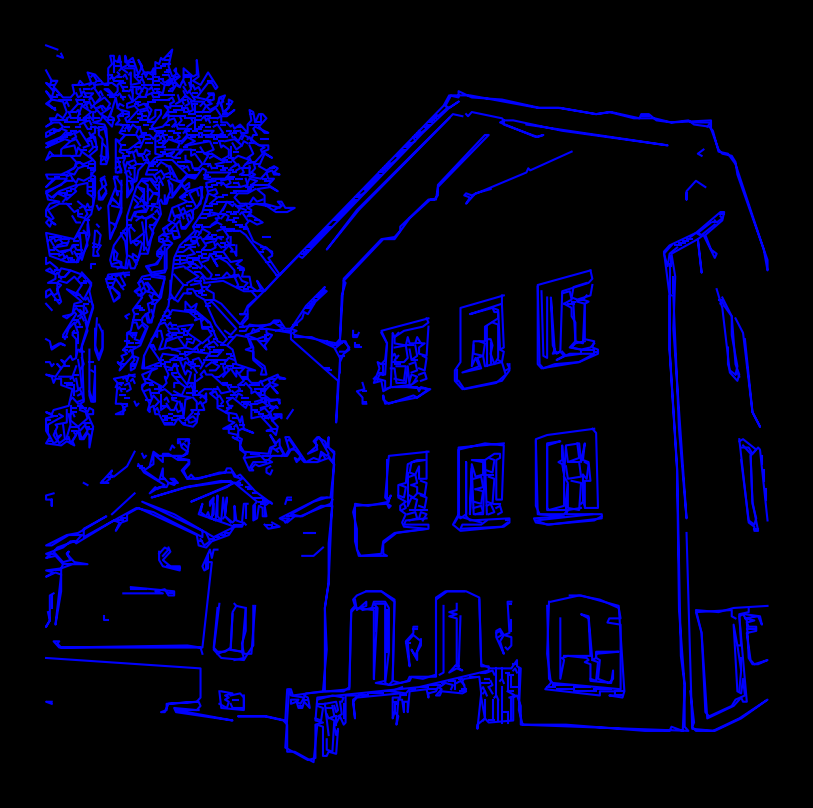

In [29]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(512/50, 512/50))
fig.patch.set_facecolor('black')

for contour in ordered_contours:
    contour = np.array(contour)
    x_approx = contour[:, :, 0].flatten()
    y_approx = contour[:, :, 1].flatten()
    plt.plot(x_approx, y_approx, color='blue')

plt.gca().invert_yaxis()
plt.axis('off')

plt.show()

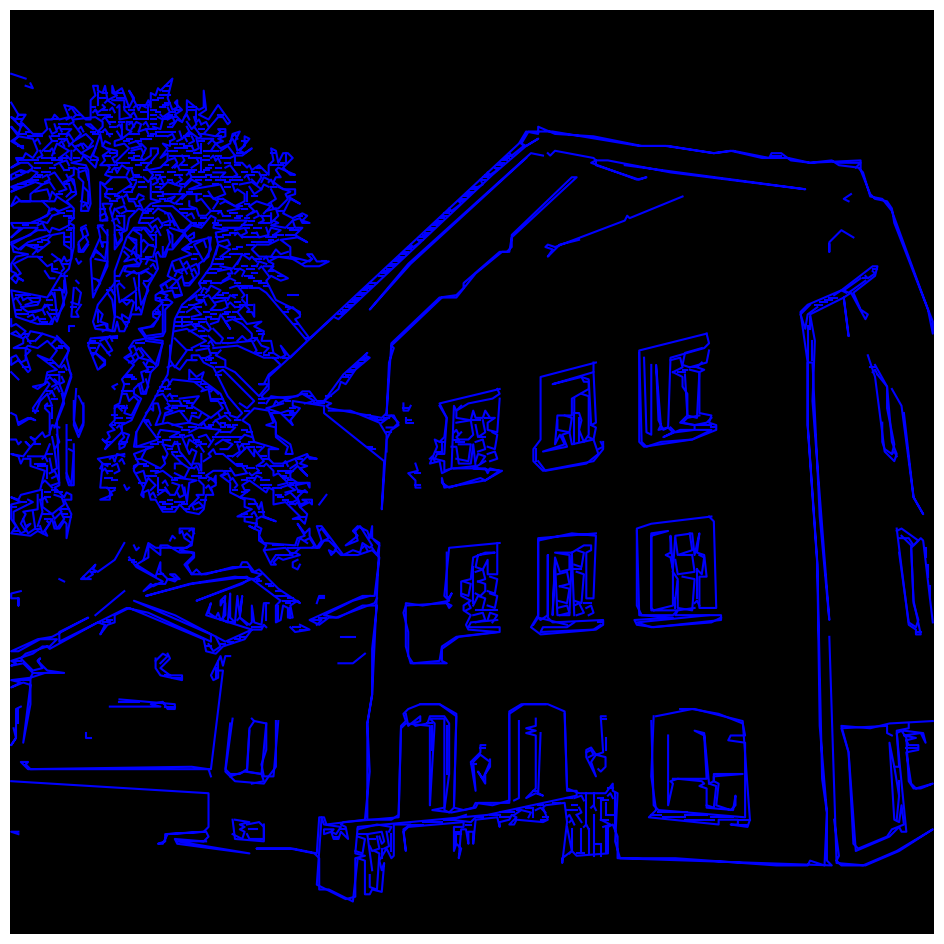

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 12))
plt.imshow(cv2.cvtColor(np.zeros_like(cv2.resize(edges, (edges.shape[1] // risize_factor, edges.shape[0] // risize_factor)), dtype=np.uint8), cv2.COLOR_GRAY2BGR), cmap='gray')

for edge_approx2 in ordered_contours:
    x_approx = edge_approx2[:, :, 0].flatten()
    y_approx = edge_approx2[:, :, 1].flatten()
    plt.plot(x_approx, y_approx, color='blue')

plt.axis('off')
plt.show()